# Gesture Recognition with CAPG DBA dataset

In this preliminary effort, we will try to perform hand gesture recognition from CAPG DBA dataset.

In this version:

- EMG data is normalized with the recorded MVC data
- EMG data (already preprocessed) **will not be processed** further.
- There is **no feature engineering**; raw EMG data will be used.
- **2D CNN** architecture used in the Capg paper will be used.
- **Input** to the model is 8 x 6 image containing 8 bands of 16 HD-EMG channels, with no temporal information at all.
- **Training data:** 5 trials per subject per gesture
- **Test data:** 5 trials per subject per gesture

**NOTE** This code has been tested with:
```
    numpy version:        1.23.5
    scipy version:        1.9.3
    sklearn version:      1.2.0
    seaborn version:      0.12.1
    pandas version:       1.5.2
    torch version:        1.12.1+cu113
    matplotlib version:   3.6.2
    CUDA version:         11.2
```

## 1- Preliminaries

### Imports

In [1]:
import sys, os
direc = os.getcwd()
print("Current Working Directory is: ", direc)
KUACC = False
if "scratch" in direc: # We are using the cluster
    KUACC = True
    homedir = os.path.expanduser("~")
    os.chdir(os.path.join(homedir,"REPO/comp541-project/capg_replica"))
    direc = os.getcwd()
    print("Current Working Directory is now: ", direc)
sys.path.append("../src/")
sys.path.append("../data/")
import torch
import torch.nn as nn
from datasets_torch import *
from models_torch import *
from utils_torch import *
from datetime import datetime
import pandas as pd
import numpy as np
import scipy as sp
import sklearn
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, classification_report, confusion_matrix, accuracy_score, f1_score
import matplotlib
import matplotlib.pyplot as plt
from copy import deepcopy
import statistics
import json
from IPython.display import display

# Print versions
print("numpy version:       ", np.__version__)
print("scipy version:       ", sp.__version__)
print("sklearn version:     ", sklearn.__version__)
print("seaborn version:     ", sns.__version__)
print("pandas version:      ", pd.__version__)
print("torch version:       ", torch.__version__)
print("matplotlib version:  ", matplotlib.__version__)


# Checking to see if CUDA is available for us
print("Checking to see if PyTorch recognizes GPU...")
print(torch.cuda.is_available())

# Whether to use latex rendering in plots throughout the notebook
USE_TEX = False
FONT_SIZE = 12

# Setting matplotlib plotting variables
if USE_TEX:
    plt.rcParams.update({
        "text.usetex": True,
        "font.size": FONT_SIZE,
        "font.family": "serif",
        "font.serif": ["Computer Modern Roman"]
    })
else:
    plt.rcParams.update({
        "text.usetex": False,
        "font.size": FONT_SIZE,
        "font.family": "serif",
        "font.serif": ["Times New Roman"]
    })

# Do not plot figures inline (only useful for cluster)
# %matplotlib

Current Working Directory is:  /scratch/users/pniaz20/REPO/comp541-project/capg_replica
Current Working Directory is now:  /scratch/users/pniaz20/REPO/comp541-project/capg_replica
numpy version:        1.22.0
scipy version:        1.4.1
sklearn version:      1.0.2
seaborn version:      0.11.2
pandas version:       1.5.2
torch version:        1.12.1+cu113
matplotlib version:   3.5.1
Checking to see if PyTorch recognizes GPU...
True


## 2- Hyperparameters and Settings

### General settings of the study

In [2]:
study = {
    'code':'capg_replica/capg_dba_v001',
    'package':'torch',
    'dataset':'capg',
    'subdataset':'dba'
}

In [3]:
hparams = {
    "model_name": autoname("capg_replica_dba_v001"),
    # General hyperparameters
    "in_features": 128,
    "out_features": 1,
    # Sequence hyperparameters
    "in_seq_len_sec": 0,
    "out_seq_len_sec": 0,
    "data_sampling_rate_Hz": 1000.0,
    "data_downsampling": 1,
    "sequence_downsampling": 1,
    "in_seq_len": 0,
    "out_seq_len": 0,
    "validation_data": [0.05,'testset']
}

## 3- Data Processing

### Load and concatenate data

In [4]:
data_dir = "../data/CAPG/parquet"
def load_single_capg_dataset(data_dir, db_str:str="dba"):
    data_lst = []
    for i,file in enumerate(os.listdir(data_dir)):
        if file.endswith(".parquet") and db_str in file:
            print("Loading file: ", file)
            data_lst.append(pd.read_parquet(os.path.join(data_dir, file)))
    data = pd.concat(data_lst, axis=0, ignore_index=True)
    return data
dba_tot = load_single_capg_dataset(data_dir, db_str="dba")
dba_mvc = dba_tot.loc[dba_tot["gesture"].isin([100, 101])]
dba = dba_tot.loc[~dba_tot["gesture"].isin([100, 101])]
print("dba_tot shape: ", dba_tot.shape)
print("dba_mvc shape: ", dba_mvc.shape)
print("dba shape: ", dba.shape)
print("columns: ")
print(dba_tot.columns)

Loading file:  dba_subj_8.parquet
Loading file:  dba_subj_10.parquet
Loading file:  dba_subj_2.parquet
Loading file:  dba_subj_5.parquet
Loading file:  dba_subj_14.parquet
Loading file:  dba_subj_12.parquet
Loading file:  dba_subj_4.parquet
Loading file:  dba_subj_11.parquet
Loading file:  dba_subj_17.parquet
Loading file:  dba_subj_16.parquet
Loading file:  dba_subj_18.parquet
Loading file:  dba_subj_6.parquet
Loading file:  dba_subj_15.parquet
Loading file:  dba_subj_3.parquet
Loading file:  dba_subj_9.parquet
Loading file:  dba_subj_13.parquet
Loading file:  dba_subj_1.parquet
Loading file:  dba_subj_7.parquet
dba_tot shape:  (1476000, 131)
dba_mvc shape:  (36000, 131)
dba shape:  (1440000, 131)
columns: 
Index(['subject', 'gesture', 'trial', 'b_1_c_1', 'b_1_c_2', 'b_1_c_3',
       'b_1_c_4', 'b_1_c_5', 'b_1_c_6', 'b_1_c_7',
       ...
       'b_8_c_7', 'b_8_c_8', 'b_8_c_9', 'b_8_c_10', 'b_8_c_11', 'b_8_c_12',
       'b_8_c_13', 'b_8_c_14', 'b_8_c_15', 'b_8_c_16'],
      dtype='obje

### Normalize EMG Data

Here the recorded MVC values will be used for normalizaing EMG data

In [5]:
max_mvc = dba_mvc.iloc[:,3:].max(axis=0)
del dba_mvc
# print("max_mvc for 5 first channels: ")
# print(max_mvc[:5])
# print("shape of max_mvc: ", max_mvc.shape)
# print("max of dba before normalization: (first five)")
# print(dba.iloc[:,3:].max(axis=0)[:5])
dba.iloc[:,3:] = dba.iloc[:,3:].div(max_mvc, axis=1)
# print("max of dba_norm after normalization: ")
# print(dba_norm.iloc[:,3:].max(axis=0)[:5])

/tmp/ipykernel_41684/1353078018.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dba.iloc[:,3:] = dba.iloc[:,3:].div(max_mvc, axis=1)


### Generate tabulated data (and update hyperparameters accordingly)

In [6]:
input_cols = list(dba.iloc[:,3:].columns)
data_processed = generate_cell_array(
    dba, hparams,
    subjects_column="subject", conditions_column="gesture", trials_column="trial",
    input_cols=input_cols, output_cols=["gesture"], specific_conditions=None,
    input_preprocessor=None,
    output_preprocessor=None,
    input_postprocessor=lambda arr: arr.reshape(-1,1,8,16),
    subjects_for_testing=None, 
    trials_for_testing=[6,7,8,9,10],
    input_scaling=False, output_scaling=False, input_forward_facing=True, output_forward_facing=True, 
    data_squeezed=False,
    input_towards_future=False, output_towards_future=False, 
    output_include_current_timestep=True,
    use_filtered_data=False, #lpcutoff=CUTOFF, lporder=FILT_ORDER, lpsamplfreq=SAMPL_FREQ,
    return_data_arrays_orig=False,
    return_data_arrays_processed=False,
    return_train_val_test_arrays=False,
    return_train_val_test_data=True,
    verbosity=1
)

# Get rid of things we won't need anymore
del dba, dba_tot

# Correct output feature count (this is buggy behavior and should be fixed)
hparams['out_features'] = 8
study['hparams'] = hparams

# subjects:    18
# conditions:  8
# trials:      10


subjects used for testing:    []
conditions used for testing:  []
trials used for testing:      [6, 7, 8, 9, 10]


Iterating through all trials ...

Concatenating arrays and generating outputs ...
Validation data source:   testset
Validation data portion:  0.05
x_train:  (720000, 1, 8, 16)
y_train:  (720000, 1)
x_val:  (36000, 1, 8, 16)
y_val:  (36000, 1)
x_test:  (684000, 1, 8, 16)
y_test:  (684000, 1)
Constructing output dictionary ...
Size of output dictionary in bytes:  743102942
Done.



In [7]:
# Inputs MUST have shape (batch_size, num_channels, seq_length) for 1D CNN (opposite of RNN)
x_train = data_processed["x_train"]#.transpose(0,2,1)
x_val = data_processed["x_val"]#.transpose(0,2,1)
x_test = data_processed["x_test"]#.transpose(0,2,1)
# Outputs MUST be zero-indexed class labels
y_train = data_processed["y_train"] - 1
y_val = data_processed["y_val"] - 1
y_test = data_processed["y_test"] - 1
del data_processed
print("x_train shape: ", x_train.shape)
print("x_val shape: ", x_val.shape)
print("x_test shape: ", x_test.shape)
print("y_train shape: ", y_train.shape)
print("y_val shape: ", y_val.shape)
print("y_test shape: ", y_test.shape)

x_train shape:  (720000, 1, 8, 16)
x_val shape:  (36000, 1, 8, 16)
x_test shape:  (684000, 1, 8, 16)
y_train shape:  (720000, 1)
y_val shape:  (36000, 1)
y_test shape:  (684000, 1)


In [8]:
y_train = y_train.squeeze()
y_val = y_val.squeeze()
y_test = y_test.squeeze()

In [9]:
train_set = TensorDataset(torch.from_numpy(x_train).float(), torch.from_numpy(y_train).long())
val_set = TensorDataset(torch.from_numpy(x_val).float(), torch.from_numpy(y_val).long())
test_set = TensorDataset(torch.from_numpy(x_test).float(), torch.from_numpy(y_test).long())

## 3- Training

In [10]:
class CapgMyoModel(nn.Module):
    def __init__(self):
        super(CapgMyoModel, self).__init__()
        layers = []
        
        layers.append(nn.BatchNorm2d(1))
        layers.append(nn.Conv2d(in_channels=1, out_channels=64, kernel_size=[3,3], padding='same'))
        layers.append(nn.BatchNorm2d(64))
        layers.append(nn.ReLU())
        
        layers.append(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=[3,3], padding='same'))
        layers.append(nn.BatchNorm2d(64))
        layers.append(nn.ReLU())
        
        layers.append(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=[1,1], padding='same'))
        layers.append(nn.BatchNorm2d(64))
        layers.append(nn.ReLU())
        
        layers.append(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=[1,1], padding='same'))
        layers.append(nn.BatchNorm2d(64))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout2d(0.5))
        
        layers.append(nn.Flatten())
        
        layers.append(nn.Linear(64*8*16, 512))
        layers.append(nn.BatchNorm1d(512))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(0.5))
        
        layers.append(nn.Linear(512, 512))
        layers.append(nn.BatchNorm1d(512))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(0.5))
        
        layers.append(nn.Linear(512, 128))
        layers.append(nn.BatchNorm1d(128))
        layers.append(nn.ReLU())
        
        layers.append(nn.Linear(128, 8))
        self.net = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.net(x)
        
model = CapgMyoModel()
print(model)        

CapgMyoModel(
  (net): Sequential(
    (0): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), padding=same)
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), padding=same)
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): Dropout2d(p=0.5, inplace=False)
    (14): Flatten(start_dim=1, end_dim=-1)
    (15): Linear(in_features=8192, out_features=512, bias=True)
    (16): Batc

In [11]:
history = train_pytorch_model(
    model, [train_set, val_set], batch_size=1024, loss_str='crossentropy', optimizer_str='adam', 
    optimizer_params={'weight_decay':0.0001}, loss_function_params=None, learnrate=0.1, 
    learnrate_decay_gamma=0.95, epochs=200, validation_patience=10, 
    verbose=1, script_before_save=True, saveto=None, num_workers=0)

Total number of data points:      756000
Number of training data points:   720000
Number of validation data points: 36000
Number of training batches:    704
Number of validation batches:  36
Batch size:                    1024
Shape of training input from the dataloader:   torch.Size([1024, 1, 8, 16])
Shape of training output from the dataloader:  torch.Size([1024])
Shape of validation input from the dataloader:   torch.Size([1024, 1, 8, 16])
Shape of validation output from the dataloader:  torch.Size([1024])
Selected device:  cuda:0
The learning rate has an exponential decay rate of 0.95000.
Classification problem detected. We will look at accuracies.


Training Progress:  90%|████████████████████████████████████    | 180/200 [1:15:44<08:24, 25.25s/it]

Validation loss not improved for more than 11 epochs.
Early stopping criterion with validation loss has been reached. Stopping training at 180 epochs...
Finished Training.
Training process took 4544.27 seconds.
Done training.


In [12]:
study['training_history'] = history
json.dump(study, open(make_path("../results/"+hparams["model_name"]+"/study.json"), "w"), indent=4)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


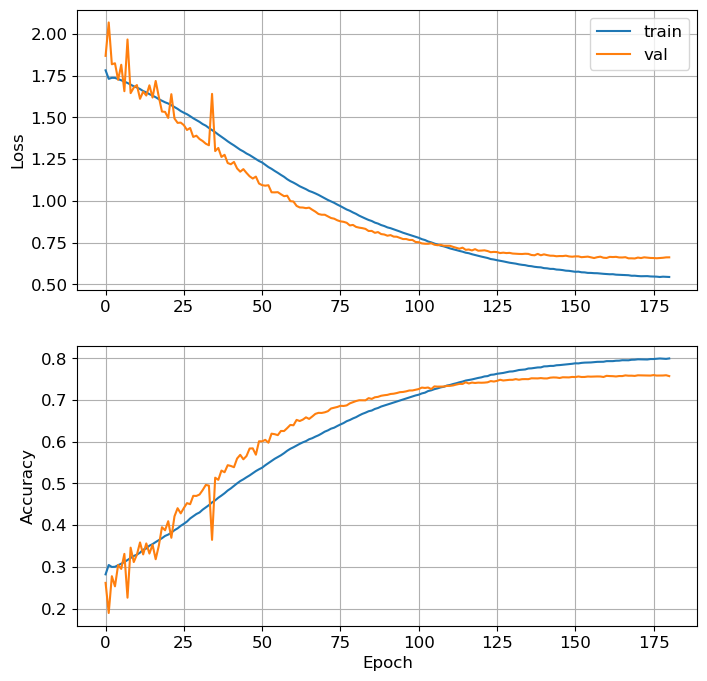

In [13]:
# Plot training history
plt.figure(figsize=(8,8), dpi=100)
plt.subplot(2,1,1)
plt.grid(True)
plt.plot(history["training_loss"], label="train")
plt.plot(history["validation_loss"], label="val")
# plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.subplot(2,1,2)
plt.grid(True)
plt.plot(history["training_metrics"], label="train")
plt.plot(history["validation_metrics"], label="val")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
# plt.legend(loc="lower right")
plt.subplots_adjust(
    hspace=0.2
)

plt.savefig(make_path("../results/"+hparams['model_name']+"/training_history.png"), dpi=300)